In [299]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pytesseract as tess
import re

In [300]:
def read_img(filename):
    path = os.path.join('../images', filename)
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
def display(image):
    dpi = 80

    height, width  = image.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(image, cmap='gray')

    plt.show()
    
def grayscale_conversion(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def thresholding(grayscale_image):
    _, binary_image = cv2.threshold(grayscale_image, 140, 255, cv2.THRESH_BINARY)
    return binary_image

def find_contours(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return  contours

def region_of_interest(binary_image):
    contours = find_contours(binary_image)
    max_contour = max(contours, key=cv2.contourArea)
    
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [max_contour], -1, (255,), thickness=cv2.FILLED)
    
    # display(mask)
    
    res = cv2.bitwise_and(binary_image, binary_image, mask=mask)
    
    x, y, w, h = cv2.boundingRect(max_contour)
    roi = res[y:y+h, x:x+w]
    return roi

def reduce_noise(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def crop_img(image, coord):
    x, y, w, h = coord[0], coord[1], coord[2], coord[3]
    return image[y:y+h, x:x+w]

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory {} created".format(path))
        return 
    print("Directory {} already exists".format(path))
        



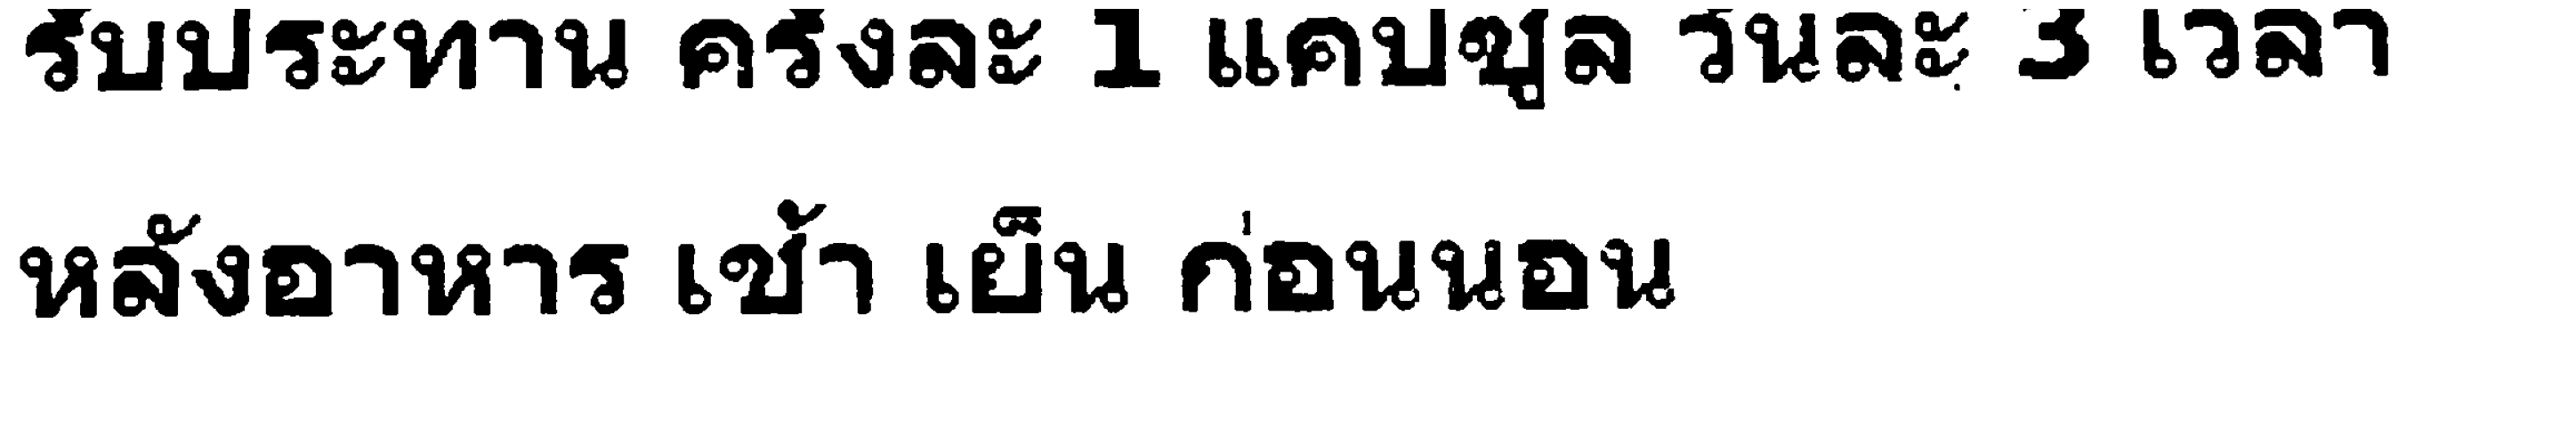

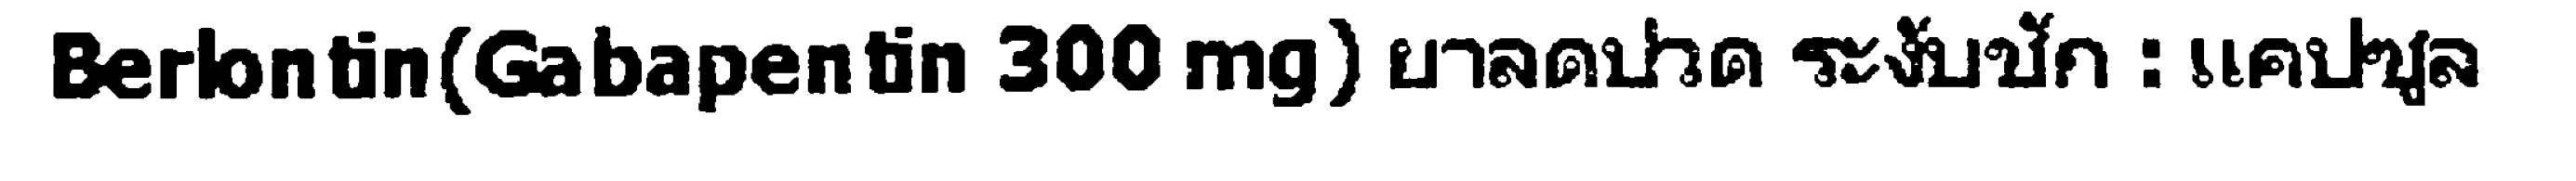

In [350]:
filename = 'img1'
file_extension = '.jpg'

img = read_img(filename + file_extension)
# display(img)
img = reduce_noise(img)
# display(img)
gray = grayscale_conversion(img)
# display(gray)
binary = thresholding(gray)
# display(binary)
roi = region_of_interest(binary)
# display(roi)
# create_directory('./temp')
# path = 'temp/' + filename + '_binary' + file_extension
# cv2.imwrite(path, roi)
usage = crop_img(roi, (160, 610, 2300, 370))
display(usage)
name = crop_img(roi, (100, 1400, 2200, 140))
display(name)


In [351]:
usage_text = tess.image_to_string(usage, lang='tha')
name_text = tess.image_to_string(name, lang='eng+tha')
print(usage_text)
print('----------')
print(name_text.replace(" ", ""))

รบประทาน ครงละ 1แคบสฆูลวนละ 2 6วณา

หลังอาหารเช้าเย็น ก่อนนอน

----------
Berlontin(Gabapentin300mg)ยาลดป่วดระงับชัก:แคปซูล


In [352]:
def clean_text(text):
    res = ''
    for line in text.splitlines():
        if line == '':
            continue
        res = res + line + ' '
    return res.strip()

def check_period(text):
    keywords = ['เช้า', 'กลางวัน', 'เย็น', 'ก่อนนอน']
    res = {'เช้า': False, 'กลางวัน': False, 'เย็น': False, 'ก่อนนอน': False}
    period_type = False
    for keyword in keywords:
        found = re.search(keyword, text)
        if found:
            period_type = True
            res[keyword] = True
    if period_type:
        return res
    return None

def check_hour(text):
    pattern = r'.+ ทุกๆ (\d+) (.+)'
    match = re.search(pattern, text)
    print(match)
    if match is None:
        return None
    num = match.group(1)
    unit = match.group(2)
    return {'num': num, 'unit': unit}

def check_frequency(text):
    keywords = ['วันเว้นวัน']
    for keyword in keywords:
        found = re.search(keyword, text)
        if found:
            return keyword
    return None

def extract_data(text):
    res = {
    'drug_name': name_text,
    'usage': usage_text,
    'notification_type': '',
    'notify': [],
    'frequency': 'ทุกวัน',
}
    freq = check_frequency(text)
    if freq:
        res['frequency'] = freq
    ok = check_period(text)
    if ok:
        res['notification_type'] = 'period'
        res['notify'] = ok
        return res
    ok = check_hour(text)
    if ok:
        res['notification_type'] = 'hour'
        res['notify'] = ok
        return res
    
    return None



In [353]:
usage_text = clean_text(usage_text)
name_text = clean_text(name_text).replace(' ', '')
# print(usage_text)
# print('----------')
# print(name_text.replace(" ", ""))

data = extract_data(usage_text)
if data:
    print('ok')
    print(data)
else:
    print('error')


ok
{'drug_name': 'Berlontin(Gabapentin300mg)ยาลดป่วดระงับชัก:แคปซูล', 'usage': 'รบประทาน ครงละ 1แคบสฆูลวนละ 2 6วณา หลังอาหารเช้าเย็น ก่อนนอน', 'notification_type': 'period', 'notify': {'เช้า': True, 'กลางวัน': False, 'เย็น': True, 'ก่อนนอน': True}, 'frequency': 'ทุกวัน'}
